<a href="https://colab.research.google.com/github/abksyed/EVA4/blob/master/S5/EVA4_S5_Assignment_iter06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Statements

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Targets

**Overall Target to Acheive**
 

1.   99.4% (this must be consistently shown in your last few epochs, and not a one-time achievement)
2.   Less than or equal to 15 Epochs
3.   Less than 10000 Parameters

*Target Acheived in Last Iteration*

1.   Parameters Used: **8464**
1.   Test Accuracy: **99.60%**
2.   Training Accuracy: **99.37%**
2.   Epochs Used: **15**

*Target for this Iteration:*

1.   Use DropOut(3%), to increase challenge for Training
2.   Create gap between training and testing accuracy.

#Raw Data Statistics

In [2]:
#Getting to know Data
data = datasets.MNIST('./data', train= True, transform= transforms.Compose([transforms.ToTensor(),]), download= True)

exp = data.data
exp = data.transform(exp.numpy())

print('Train Statistics')
print(' - Numpy Shape:', data.data.cpu().numpy().shape)
print(' - Tensor Shape:', data.data.size())
print(' - min:', torch.min(exp))
print(' - max:', torch.max(exp))
print(' - mean:', torch.mean(exp))
print(' - std:', torch.std(exp))
print(' - var:', torch.var(exp))

Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


#Transforming Raw Data to Normalized Data

In [0]:
#Transforming Data (Normalizing to mean=1, std= 0)
train_transform = transforms.Compose([
                                      transforms.RandomRotation((-12.0,12.0), fill=(1,)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1311,), (0.3081,))
]
)

test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1311,),(0.3081,))
])

#Creating Train/Test Split

In [0]:
#Getting Train and Test Data
train = datasets.MNIST('./data', train= True, transform= train_transform)
test = datasets.MNIST('./data', train= False, transform= test_transform)

#Dataloader Arguments & Test/Train Dataloaders

In [5]:
seed = 1

#CUDA Availability
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

#For Reproducibility
torch.manual_seed(seed)

if cuda:
    torch.cuda.manual_seed(seed)

dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory= True) if cuda else dict(shuffle= True, batch_size=64)

#Train Dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

#Test Dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


#**THE MODEL**

In [0]:
dr= 0.03
class Net(nn.Module):

  def __init__(self):

    super(Net, self).__init__()

    #Input Block - Input= 28
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels= 1, out_channels= 8, kernel_size= 3, padding= 1, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Dropout2d(dr),
    ) #Output= 28 / ReceptiveField= 3

    #Convolution Block - Input= 28
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels= 8, kernel_size= 3, padding= 1, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Dropout2d(dr),
    ) #Output= 28 / ReceptiveField= 5

    #Max Pooling and 1x1 Convolution
    self.mp1 = nn.Sequential(
        nn.MaxPool2d(2)
    )#Output= 14 / ReceptiveField= 6

    #Convolution Block - Input= 14
    self.block3 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels= 12, kernel_size= 3, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout2d(dr), 
        #Output= 12 / ReceptiveField= 10
        nn.Conv2d(in_channels= 12, out_channels= 12, kernel_size= 3, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout2d(dr),
    ) #Output= 10 / ReceptiveField= 14  

    #Convolution Block - Input= 10
    self.block4 = nn.Sequential(
        nn.Conv2d(in_channels= 12, out_channels= 12, kernel_size= 3, padding= 0, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout2d(dr),
        #Output= 8 / ReceptiveField= 18
        nn.Conv2d(in_channels= 12, out_channels= 16, kernel_size= 3, padding= 0, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(dr),
    ) #Output= 6 / ReceptiveField= 22
    
    #Convolution Block - Input= 6
    self.block5 = nn.Sequential(
        nn.Conv2d(in_channels= 16, out_channels= 16, kernel_size= 3, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(dr),
    ) #Output= 4 / ReceptiveField= 26

    #GAP - Input 3
    self.gap = nn.AvgPool2d(4)
    #Output= 1 / ReceptiveField= 32
    
    self.conv = nn.Conv2d(in_channels= 16, out_channels= 10, kernel_size= 1, bias= False)

  def forward(self,x):

     x = self.block1(x)
     x = self.block2(x)
     x = self.mp1(x)
     x = self.block3(x)
     x = self.block4(x)
     x = self.block5(x)
     x = self.gap(x)
     x = self.conv(x)
     x = x.view(-1,10)

     return F.log_softmax(x, dim=-1)

#Inspecting Model Parameters

In [9]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
         Dropout2d-8            [-1, 8, 28, 28]               0
         MaxPool2d-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 12, 12, 12]             864
             ReLU-11           [-1, 12, 12, 12]               0
      BatchNorm2d-12           [-1, 12, 12, 12]              24
        Dropout2d-13           [-1, 12, 12, 12]               0
           Conv2d-14           [-1

#Training and Testing

In [0]:
from tqdm import tqdm

train_loss = []
test_loss = []

train_acc = []
train_endacc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    y_pred = model(data)

    loss = F.nll_loss(y_pred, target)
    train_loss.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim= True)
    correct+= pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100 * correct/processed)
  train_endacc.append(train_acc[-1])

In [0]:
def test(model, device, test_loader):
  model.eval()
  correct= 0
  tloss= 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)

      output = model(data)

      tloss+= F.nll_loss(output, target, reduction= 'sum').item()
      pred= output.argmax(dim= 1, keepdim= True)
      correct+= pred.eq(target.view_as(pred)).sum().item()

  tloss /= len(test_loader.dataset)
  test_loss.append(tloss)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        tloss, correct, len(test_loader.dataset),
        100 * correct/len(test_loader.dataset)))
  
  test_acc.append(100 * correct/len(test_loader.dataset))

#Running the Model

In [12]:
from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum= 0.9)
epochs = 15
scheduler = StepLR(optimizer, step_size= 7, gamma= 0.25)

for epoch in range(epochs):
  print('EPOCH: ', epoch+1)
  train(model, device, train_loader, optimizer, epoch)
  scheduler.step()
  test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH:  1


Loss=0.039268895983695984 Batch_id=937 Accuracy=91.78: 100%|██████████| 938/938 [00:16<00:00, 56.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9849/10000 (98.49%)

EPOCH:  2


Loss=0.041229285299777985 Batch_id=937 Accuracy=97.35: 100%|██████████| 938/938 [00:16<00:00, 56.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9878/10000 (98.78%)

EPOCH:  3


Loss=0.02338045835494995 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:16<00:00, 57.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9920/10000 (99.20%)

EPOCH:  4


Loss=0.07367652654647827 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:18<00:00, 51.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9907/10000 (99.07%)

EPOCH:  5


Loss=0.03686937689781189 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:18<00:00, 51.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9931/10000 (99.31%)

EPOCH:  6


Loss=0.06049904227256775 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:17<00:00, 52.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9919/10000 (99.19%)

EPOCH:  7


Loss=0.033810749650001526 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:17<00:00, 52.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9925/10000 (99.25%)

EPOCH:  8


Loss=0.0153055340051651 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:17<00:00, 53.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9947/10000 (99.47%)

EPOCH:  9


Loss=0.00603349506855011 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:17<00:00, 53.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9945/10000 (99.45%)

EPOCH:  10


Loss=0.0047839730978012085 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:17<00:00, 52.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9950/10000 (99.50%)

EPOCH:  11


Loss=0.03117552399635315 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:17<00:00, 53.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.42%)

EPOCH:  12


Loss=0.012305110692977905 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:17<00:00, 52.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9945/10000 (99.45%)

EPOCH:  13


Loss=0.02035561203956604 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:17<00:00, 53.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9955/10000 (99.55%)

EPOCH:  14


Loss=0.016096174716949463 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:17<00:00, 52.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9954/10000 (99.54%)

EPOCH:  15


Loss=0.08653292059898376 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:17<00:00, 52.63it/s]



Test set: Average loss: 0.0158, Accuracy: 9954/10000 (99.54%)



Text(0.5, 1.0, 'Test Accuracy')

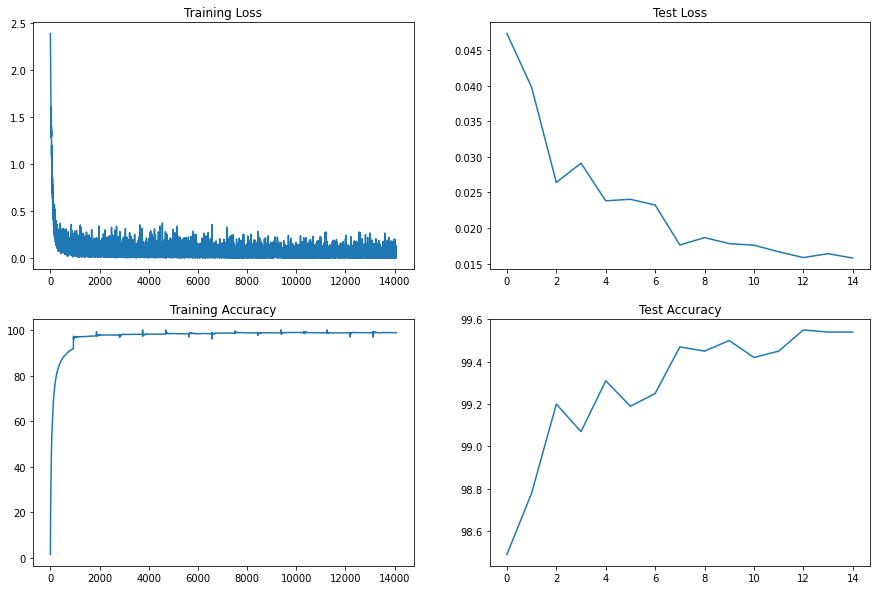

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_loss)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

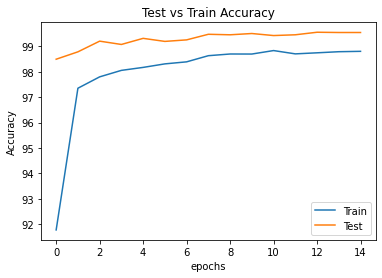

In [14]:
plt.axes(xlabel= 'epochs', ylabel= 'Accuracy')
plt.plot(train_endacc)
plt.plot(test_acc)
plt.title('Test vs Train Accuracy')
plt.legend(['Train', 'Test'])

In [15]:
print(f'Max Training Loss {min(train_loss)} with Max Training Accuracy {max(train_endacc)}\n')
print(f'Max Testing Loss {min(test_loss)} with Max Testing Accuracy {max(test_acc)}')

Max Training Loss 0.0008280426263809204 with Max Training Accuracy 98.83

Max Testing Loss 0.0157775673866272 with Max Testing Accuracy 99.55


#Results:



1.   Parameters Used: **8464**
1.   Test Accuracy: **99.55%**
2.   Training Accuracy: **98.83%**
2.   Epochs Used: **15**



#Analysis:



1.   As expected training accuracy is decreased, but test accuracy remains almost same.
2.   The model can be further pushed or challenged even more by increasing DropOut percentage. But again, it's not better to use BatchNorm with DropOut.






